# All We need is Leak Validation(LV) ?

* **if you like this kernel, please upvote original kernels.**
* update leakdata

this kernel is still work in progress, but i hope you can find something usefull from this.

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.metrics import mean_squared_error

In [2]:

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
%%time
root = Path('../input/ashrae-feather-format-for-fast-loading')

train_df = pd.read_feather(root/'train.feather')
test_df = pd.read_feather(root/'test.feather')
#weather_train_df = pd.read_feather(root/'weather_train.feather')
#weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



CPU times: user 2.45 s, sys: 1.65 s, total: 4.1 s
Wall time: 7.27 s


In [4]:
# i'm now using my leak data station kernel to shortcut.
leak_df = pd.read_feather('../input/ashrae-leak-data-station/leak.feather')
leak_df.fillna(0, inplace=True)
print (leak_df.timestamp.min(), leak_df.timestamp.max())
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

2016-01-01 00:00:00 2018-12-31 23:00:00


In [5]:
leak_df.meter.value_counts()

0.0    7389997
1.0    2856222
3.0     963600
2.0     727682
Name: meter, dtype: int64

In [6]:
print (leak_df.duplicated().sum())

0


In [7]:
print (len(leak_df) / len(train_df))

0.5904947541810736


In [8]:
! ls ../input

ashrae-energy-prediction		ashrae-highway-kernel-route4
ashrae-feather-format-for-fast-loading	ashrae-kfold-lightgbm-without-leak-1-08
ashrae-half-and-half			ashrae-leak-data-station


In [9]:
del train_df
gc.collect()

22

# Leak Validation for public kernels(not used leak data)

In [10]:
sample_submission1 = pd.read_csv('../input/ashrae-kfold-lightgbm-without-leak-1-08/submission.csv', index_col=0)
sample_submission2 = pd.read_csv('../input/ashrae-half-and-half/submission.csv', index_col=0)
sample_submission3 = pd.read_csv('../input/ashrae-highway-kernel-route4/submission.csv', index_col=0)

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [11]:
test_df['pred1'] = sample_submission1.meter_reading
test_df['pred2'] = sample_submission2.meter_reading
test_df['pred3'] = sample_submission3.meter_reading

test_df.loc[test_df.pred3<0, 'pred3'] = 0 

del  sample_submission1,  sample_submission2,  sample_submission3
gc.collect()

test_df = reduce_mem_usage(test_df)
leak_df = reduce_mem_usage(leak_df)

Memory usage of dataframe is 1550.87 MB
Memory usage after optimization is: 1073.68 MB
Decreased by 30.8%
Memory usage of dataframe is 455.38 MB
Memory usage after optimization is: 296.00 MB
Decreased by 35.0%


In [12]:
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'pred1', 'pred2', 'pred3', 'row_id']], left_on = ['building_id', 'meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'], how = "left")
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']], on='building_id', how='left')

In [13]:
leak_df['pred1_l1p'] = np.log1p(leak_df.pred1)
leak_df['pred2_l1p'] = np.log1p(leak_df.pred2)
leak_df['pred3_l1p'] = np.log1p(leak_df.pred3)
leak_df['meter_reading_l1p'] = np.log1p(leak_df.meter_reading)

In [14]:
leak_df.head()

,building_id,meter,meter_reading,timestamp,pred1,pred2,pred3,row_id,site_id,pred1_l1p,pred2_l1p,pred3_l1p,meter_reading_l1p
0,0,0.0,173.370300,2017-01-01,186.168106,92.729485,169.533401,0,0,5.232007,4.540413,5.138931,5.161181
1,1,0.0,53.512718,2017-01-01,85.102570,41.220722,89.669403,1,0,4.455539,3.742911,4.507220,3.998434
2,2,0.0,6.143042,2017-01-01,13.020658,2.686540,12.904300,2,0,2.640532,1.304688,2.632198,1.966139
3,3,0.0,101.701469,2017-01-01,249.669037,139.413605,312.110107,3,0,5.524134,4.944592,5.746555,4.631826
4,4,0.0,1141.240723,2017-01-01,1130.942383,620.063782,1359.578369,4,0,7.031690,6.431434,7.215665,7.040747


In [15]:
leak_df[leak_df.pred1_l1p.isnull()]

,building_id,meter,meter_reading,timestamp,pred1,pred2,pred3,row_id,site_id,pred1_l1p,pred2_l1p,pred3_l1p,meter_reading_l1p


score1= 0.9892353


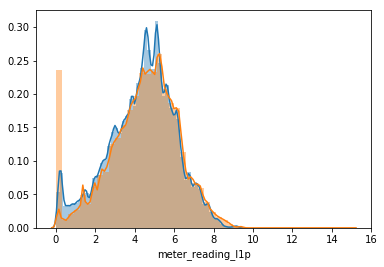

In [16]:
#ashrae-kfold-lightgbm-without-leak-1-08
sns.distplot(leak_df.pred1_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred1_l1p, leak_df.meter_reading_l1p))
print ('score1=', leak_score)

score2= 1.009389


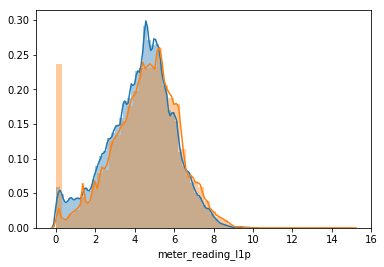

In [17]:
#ashrae-half-and-half
sns.distplot(leak_df.pred2_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred2_l1p, leak_df.meter_reading_l1p))
print ('score2=', leak_score)

score3= 1.0011902


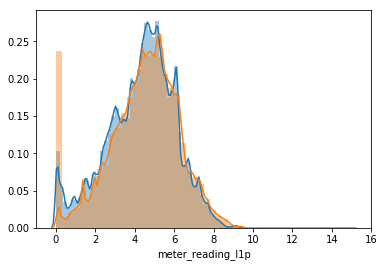

In [18]:
# meter split based
sns.distplot(leak_df.pred3_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred3_l1p, leak_df.meter_reading_l1p))
print ('score3=', leak_score)

In [19]:
# ashrae-kfold-lightgbm-without-leak-1-08 looks best

# Leak Validation for Blending

A one idea how we can use LV usefull is blending. We probably can find best blending method without LB probing and it's means we can save our submission.

mean score= 0.9817491


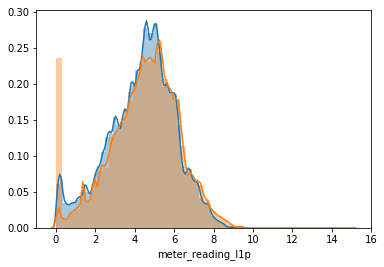

In [20]:
leak_df['mean_pred'] = np.mean(leak_df[['pred1', 'pred2', 'pred3']].values, axis=1)
leak_df['mean_pred_l1p'] = np.log1p(leak_df.mean_pred)
leak_score = np.sqrt(mean_squared_error(leak_df.mean_pred_l1p, leak_df.meter_reading_l1p))


sns.distplot(leak_df.mean_pred_l1p)
sns.distplot(leak_df.meter_reading_l1p)

print ('mean score=', leak_score)

meadian score= 0.9856688


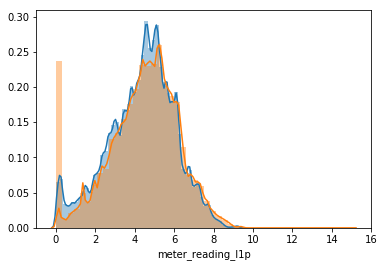

In [21]:
leak_df['median_pred'] = np.median(leak_df[['pred1', 'pred2', 'pred3']].values, axis=1)
leak_df['median_pred_l1p'] = np.log1p(leak_df.median_pred)
leak_score = np.sqrt(mean_squared_error(leak_df.median_pred_l1p, leak_df.meter_reading_l1p))

sns.distplot(leak_df.median_pred_l1p)
sns.distplot(leak_df.meter_reading_l1p)

print ('meadian score=', leak_score)

Ummm... it looks mean blending is beter than median blending

# Find Best Weight

In [22]:
N = 10
scores = np.zeros(N,)
for i in range(N):
    p = i * 1./N
    v = p * leak_df['pred1'].values + (1.-p) * leak_df ['pred3'].values
    vl1p = np.log1p(v)
    scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

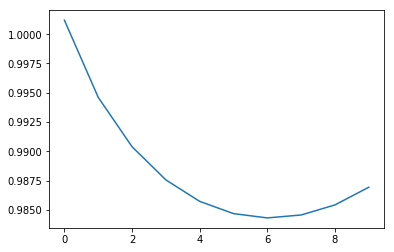

In [23]:
plt.plot(scores)

In [24]:
best_weight = np.argmin(scores) *  1./N
print (scores.min(), best_weight)

0.9843048453330994 0.6


In [25]:
# and more
scores = np.zeros(N,)
for i in range(N):
    p = i * 1./N
    v =  p * (best_weight * leak_df['pred1'].values + (1.-best_weight) * leak_df ['pred3'].values) + (1.-p) * leak_df ['pred2'].values
    vl1p = np.log1p(v)
    scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

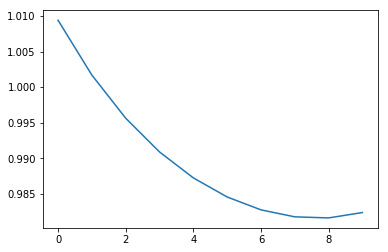

In [26]:
plt.plot(scores)

In [27]:
best_weight2 = np.argmin(scores) *  1./N
print (scores.min(), best_weight2)
# its seams better than simple mean 0.92079717

0.9816527366638184 0.8


# Heuristic way

In [28]:
v = 0.33 * leak_df['pred1'].values + 0.33 * leak_df['pred3'].values + 0.3 * leak_df['pred2'].values
vl1p = np.log1p(v)

print (np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p)))

0.98060143


# Submit

In [29]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
sample_submission['meter_reading'] = 0.33 * test_df.pred1 +  0.33 * test_df.pred3  + 0.3 * test_df.pred2
sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



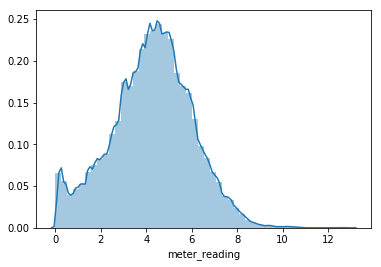

In [30]:
sns.distplot(np.log1p(sample_submission.meter_reading))

In [31]:
leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample_submission.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']

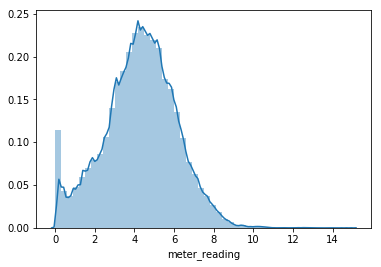

In [32]:
sns.distplot(np.log1p(sample_submission.meter_reading))

In [33]:
sample_submission.head()

,row_id,meter_reading
0,0,173.370300
1,1,53.512718
2,2,6.143042
3,3,101.701469
4,4,1141.240723


In [34]:
sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')